In [1]:
import random
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
%matplotlib inline
color = sns.color_palette()
cmap = cm.get_cmap('Spectral')

random.seed(9001)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
# import dataset
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')

products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [4]:
print ("Size of users       :", np.max(orders.user_id))
print ('================================================')
print ("Size of Products    :", products.shape[0])
print ("Size of Aisles      :", aisles.shape[0])
print ("Size of Departments :", departments.shape[0])

Size of users       : 206209
Size of Products    : 49688
Size of Aisles      : 134
Size of Departments : 21


In [5]:
products = pd.merge(products, aisles, on = ['aisle_id'])
products = pd.merge(products, departments, on = ['department_id'])
_mt = pd.merge(order_products_prior, products, on = ['product_id'])
mt = pd.merge(_mt, orders, on=['order_id','order_id'])

mt = mt.sort(columns = ["order_id", "add_to_cart_order"], axis = 0, ascending = True).reset_index(drop = True)
mt.head(3)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.000
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.000
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.000


### user clustering

In [6]:
# order situation
f = {'order_number':["max"],
     'order_dow':['min','max','mean'],
     'order_hour_of_day':['min','max','mean'],
     'days_since_prior_order':['min','max','mean']}
grouped_df = mt.groupby(["user_id"]).aggregate(f).reset_index()
grouped_df.columns = ["user_id", "max_order_number",
                      "min_order_dow","max_order_dow","mean_order_dow",
                      "min_order_hour_of_day","max_order_hour_of_day","mean_order_hour_of_day",
                      "min_days_since_prior_order","max_days_since_prior_order",
                      "mean_days_since_prior_order"]
grouped_df.head(1)

,user_id,max_order_number,min_order_dow,max_order_dow,mean_order_dow,min_order_hour_of_day,max_order_hour_of_day,mean_order_hour_of_day,min_days_since_prior_order,max_days_since_prior_order,mean_days_since_prior_order
0,1,10,1,4,2.644,7,16,10.542,0.000,30.000,20.259


In [7]:
# cross table of users and department
cust_prod = pd.crosstab(mt['user_id'], mt['department'])

cust_prod["user_id"] = cust_prod.index+1
cust_prod = cust_prod.reset_index(drop=True)
cust_prod.head(3)

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,user_id
0,0,0,0,13,3,0,0,13,0,0,...,0,0,0,0,1,0,0,5,22,2
1,0,0,2,9,3,0,1,48,21,0,...,3,1,0,0,11,1,0,36,42,3
2,0,0,0,3,0,0,0,21,2,4,...,0,0,0,0,4,0,0,38,9,4


In [8]:
df = pd.merge(grouped_df, cust_prod, on=['user_id'])
df.head()

,user_id,max_order_number,min_order_dow,max_order_dow,mean_order_dow,min_order_hour_of_day,max_order_hour_of_day,mean_order_hour_of_day,min_days_since_prior_order,max_days_since_prior_order,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
0,2,14,1,5,2.005,9,15,10.441,3.000,30.000,...,2,0,0,0,0,1,0,0,5,22
1,3,12,0,3,1.011,14,19,16.352,7.000,21.000,...,0,3,1,0,0,11,1,0,36,42
2,4,5,4,6,4.722,11,15,13.111,0.000,21.000,...,1,0,0,0,0,4,0,0,38,9
3,5,4,0,3,1.622,12,18,15.730,10.000,19.000,...,2,0,0,0,0,0,0,0,2,1
4,6,3,2,5,3.857,16,18,17.000,6.000,12.000,...,0,2,0,0,0,2,0,0,19,1


### kmeans

In [9]:
def kmeans_pca2(n_clusters, X):
    # kmeans 對顧客分群
    kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(X)
    label_kmeans = pd.DataFrame(kmeans.labels_, columns=["k_label"])
    # 降維看結果
    pca = PCA(n_components = 2)
    X_pca = pd.DataFrame(pca.fit_transform(X), columns=["pc1", "pc2"])
    df_pca = pd.concat([X_pca, label_kmeans], axis = 1)
    print(df_pca.k_label.value_counts())

    # plot PCA of Kmeans label
    fig, ax = plt.subplots(figsize=(12, 8))
    df_pca.plot(x='pc1', y='pc2', ax = ax, title="PCA of Kmaens",
                kind='scatter', s=10, c='k_label', cmap=cmap, alpha=0.5)
    plt.show()
    return df_pca


n_clusters = 4
0    145289
3     42140
2     14722
1      4057
Name: k_label, dtype: int64


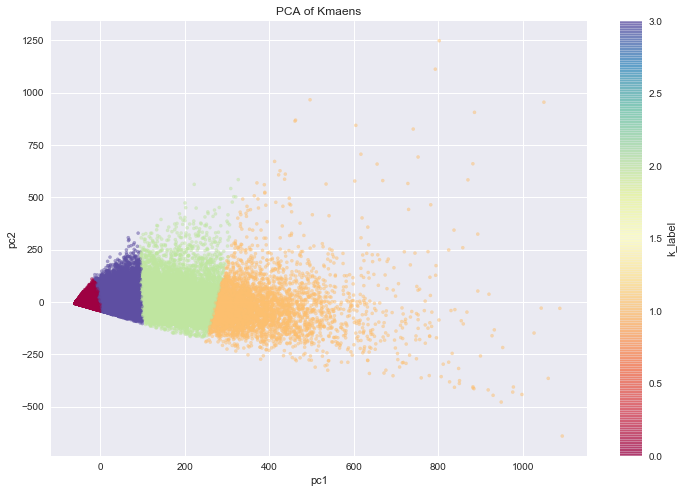

n_clusters = 6
0    131075
2     45630
4     17160
3      6671
1      3616
5      2056
Name: k_label, dtype: int64


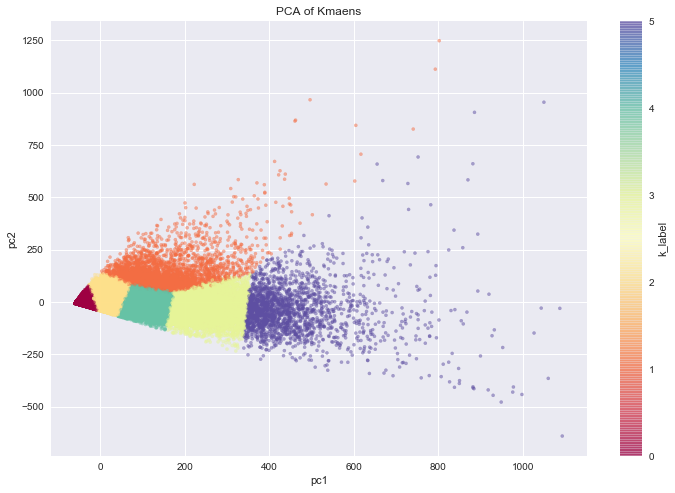

n_clusters = 8
4    112174
5     41404
0     20114
6     14518
3      7982
1      6823
7      2022
2      1171
Name: k_label, dtype: int64


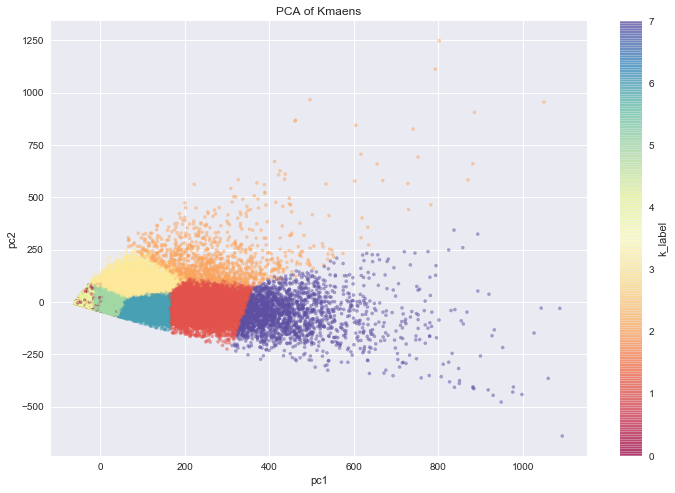

n_clusters = 10
9    102713
4     40263
2     19130
6     17407
0      9491
7      6823
1      4991
3      3747
5       987
8       656
Name: k_label, dtype: int64


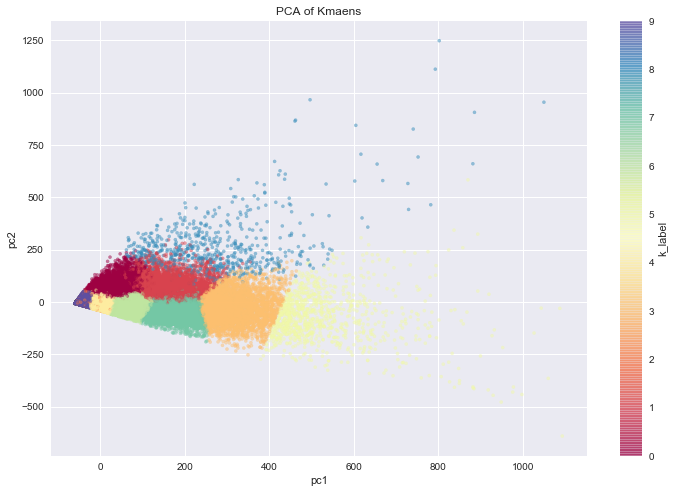

n_clusters = 12
1     99428
8     37884
7     18755
3     17194
5     12628
0      7239
4      5584
6      2628
2      2384
9      1321
11      927
10      236
Name: k_label, dtype: int64


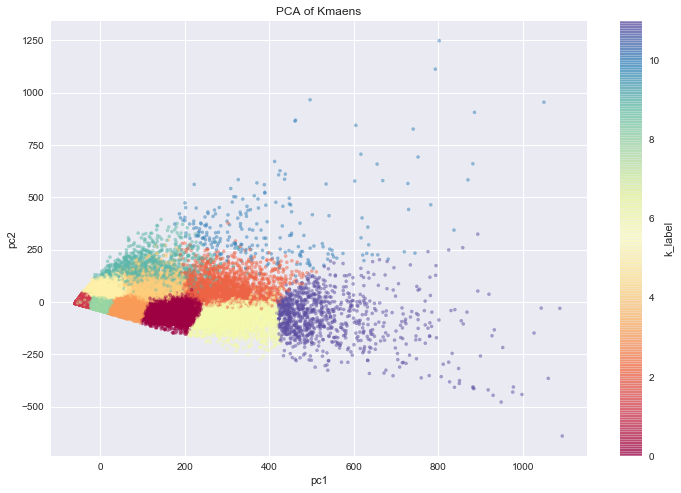

In [10]:
for i in range(4, 13, 2):
    print("n_clusters =", str(i))
    X = kmeans_pca2(i, df.drop(["user_id"], axis=1))


0    145289
3     42140
2     14722
1      4057
Name: k_label, dtype: int64


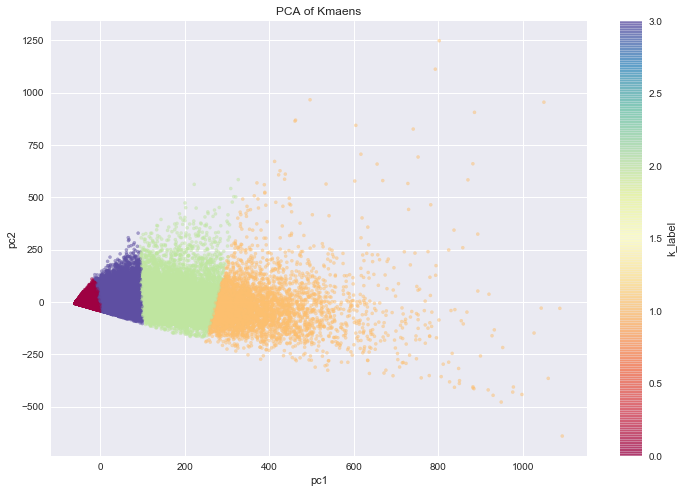

In [11]:
df_pca = kmeans_pca2(4, df.drop(["user_id"], axis=1))

(206209, 22)


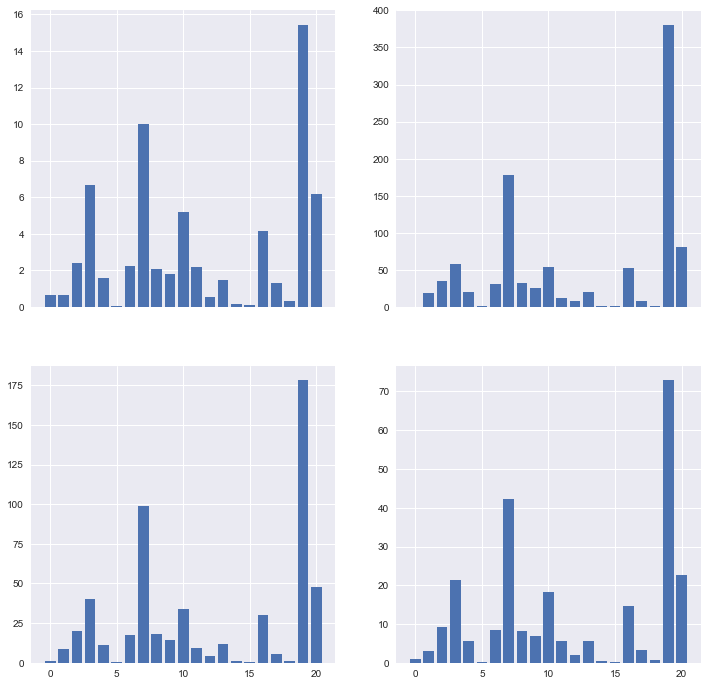

In [12]:
cust_prod["k_label"] = df_pca.k_label
cust_prod = cust_prod.drop(["user_id"], axis=1)
print (cust_prod.shape)

f,arr = plt.subplots(2,2,sharex=True,figsize=(12,12))

c0 = cust_prod[cust_prod['k_label']==0].drop('k_label',axis=1).mean()
arr[0,0].bar(range(len(cust_prod.drop('k_label', axis=1).columns)), c0)
c1 = cust_prod[cust_prod['k_label']==1].drop('k_label',axis=1).mean()
arr[0,1].bar(range(len(cust_prod.drop('k_label', axis=1).columns)), c1)
c2 = cust_prod[cust_prod['k_label']==2].drop('k_label',axis=1).mean()
arr[1,0].bar(range(len(cust_prod.drop('k_label', axis=1).columns)), c2)
c3 = cust_prod[cust_prod['k_label']==3].drop('k_label',axis=1).mean()
arr[1,1].bar(range(len(cust_prod.drop('k_label',axis=1).columns)), c3)

plt.show()

In [13]:
for i in [c0, c1, c2, c3]:
    print(i.sort_values(ascending=False)[0:15])

department
produce           15.440
dairy eggs        10.019
beverages          6.648
snacks             6.191
frozen             5.198
pantry             4.145
bakery             2.422
canned goods       2.243
household          2.194
deli               2.095
dry goods pasta    1.821
breakfast          1.565
meat seafood       1.484
personal care      1.289
alcohol            0.672
dtype: float64
department
produce           380.826
dairy eggs        178.377
snacks             81.009
beverages          57.765
frozen             53.381
pantry             51.935
bakery             35.354
deli               32.481
canned goods       30.820
dry goods pasta    25.593
meat seafood       20.187
breakfast          19.999
babies             19.138
household          11.842
personal care       7.983
dtype: float64
department
produce           178.043
dairy eggs         98.828
snacks             47.986
beverages          40.181
frozen             33.984
pantry             30.103
bakery          

> 我們可以檢查在這些貨物的數量和比例上，群集是否不同，或者一個群集的特徵是沒有列入本清單中的某些商品。  
例如，我們已經可以看到群集3的特點是“嬰兒食品配方”產品，這是其他群集的顯著區別。